In [ ]:
%matplotlib inline
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import random
import subprocess
import os

Point the following directory locations to the data you have collected from your RACECAR.

You should create `dest_img_dir` beforehand, and install `ffmpeg` on your system.

In [3]:
working_directory = "../"

# saved csv from car
driving_data = working_directory + "tests/tables/run_03_15_00_39/run_03_15_00_39.csv"

# directory location of car images
parent_dir   = working_directory + "tests/tables/run_03_15_00_39/"

# write imgs to folder
dest_img_dir = working_directory + "viz_tables/"

output_video_location = working_directory + "tables.mp4"

In [ ]:
imgs = []
ngls = []

with open(driving_data) as fh:
    for line in fh:
        l = line.split(',')
        img = l[0]
        imgs.append(parent_dir + img)
        ngl = l[1]
        ngl = float(ngl)
        ngls.append(ngl)
        
print(len(imgs), len(ngls))

In [17]:
def viz_angle(idx, img, angle, ground_truth=None):
    
    ### 
    ### TODO: add visualization for ground_truth
    ###
    
    height, width = img.shape[0], img.shape[1]
    bar_height_px = int(0.8 * height)
    bar_left_px   = int(0.2 * width)
    bar_right_px  = int(0.8 * width)
    
    # visualize bar
    cv.line(img, (bar_left_px, bar_height_px), (bar_right_px, bar_height_px), (0,255,0), thickness=8)
    
    # visualize center line
    bar_length_px      = bar_right_px - bar_left_px
    bar_half_length_px = int(bar_length_px / 2.)
    bar_center_px      = bar_half_length_px + bar_left_px
    centerline_hfht_px = 20
    cv.line(img, (bar_center_px, bar_height_px - centerline_hfht_px), 
            (bar_center_px, bar_height_px  + centerline_hfht_px),
            (0,0,0), thickness=2)

    # visualize angle
    # NOTE: positive servo angles turn left, negative-right. Here, flip the sign for visualization
    px_offset          = int(bar_half_length_px * angle) * -1
    loc                = (bar_center_px + px_offset, bar_height_px)
    cv.circle(img, loc, 4, (0,0,255), thickness=15)
    
    # report angle and frame ID
    answer = "Angle: {:+06.2f}, image {:05d}".format(angle, idx)
    font = cv.FONT_HERSHEY_SIMPLEX
    cv.putText(img,answer,(bar_left_px, bar_height_px + 35), font, 0.45,(255,255,255),1,cv.LINE_AA)
    
    return img

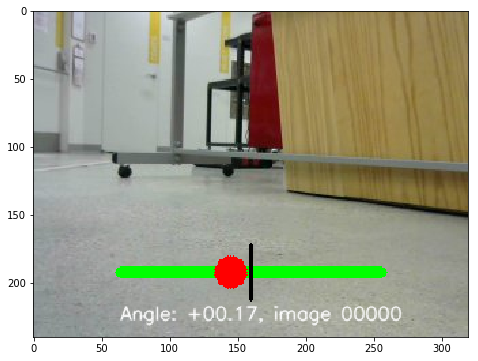

In [19]:
idx = random.randint(0,len(imgs)-1)

img = cv.imread(imgs[idx])
result= viz_angle(0, np.copy(img), ngls[idx])

fig,ax = plt.subplots()
ax.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
fig.set_size_inches(8,6)

In [ ]:
# write images with visualized angles (NOTE: overwrites any existing images)
for idx, (imgfn, ngl) in enumerate(zip(imgs, ngls)):
    if idx % 300 == 0:
        print(idx)
    img = cv.imread(imgfn)
    viz = viz_angle(idx, img, ngl)
    output_fn = dest_img_dir + "{:05d}.jpg".format(idx)
    cv.imwrite(output_fn, viz)

In [ ]:
#save video (NOTE: overwrites any existing video with the same name
ffmpeg = """ffmpeg -y -framerate 30 -pattern_type glob -i '*.jpg' -c:v libx264 -profile:v high -crf 26 -pix_fmt yuv420p {}"""

curdir = os.getcwd()
try:
    video = ffmpeg.format(output_video_location)
    os.chdir(dest_img_dir)
    subprocess.call(video, shell=True)
finally:
    os.chdir(curdir)